**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to improve and see how you stack up to others taking this course.

The steps in this notebook are:
1. Build a Random Forest model with all of your data (**X** and **y**).
2. Read in the "test" data, which doesn't include values for the target.  Predict home values in the test data with your Random Forest model.
3. Submit those predictions to the competition and see your score.
4. Optionally, come back to see if you can improve your model by adding features or changing your model. Then you can resubmit to see how that stacks up on the competition leaderboard.

## Import Train Data

In [1]:
# Code you have previously used to load data
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

# Path of the file to read. We changed the directory structure to simplify submitting to a competition
iowa_file_path = '../input/train.csv'

home_data = pd.read_csv(iowa_file_path)

# Plot Target Data and Transform

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


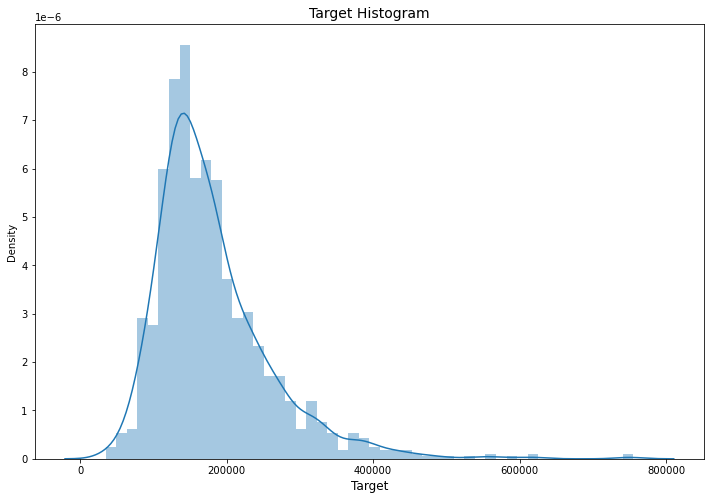

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


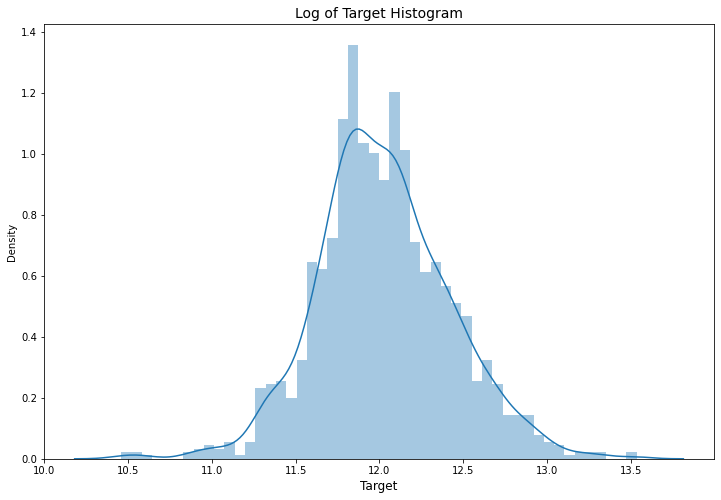

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create target object and call it y
y = home_data.SalePrice

# Plot y
plt.figure(figsize=(12,8))
sns.distplot(y, bins=50, kde=True)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

# y log transform
plt.figure(figsize=(12,8))
sns.distplot(np.log1p(y), bins=50, kde=True)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

# y log transform
y = np.log1p(y)

In [3]:
# path to file you will use for predictions
test_data_path = '../input/test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

print(home_data.shape)
print(test_data.shape)

home_data = home_data.drop(columns=['SalePrice'])

home_data = pd.concat([home_data, test_data])

print(home_data.shape)

(1460, 81)
(1459, 80)
(2919, 80)


# Split Numerical and Categorical

In [4]:
# Create X
home_data_categorical_pd  = home_data.loc[:,home_data.dtypes==np.object]
home_data_numerical_pd  = home_data.loc[:,home_data.dtypes!=np.object]
home_data_numerical_pd = home_data_numerical_pd.drop(columns=['Id'])

# Feature Engineering - NaN Columns

In [5]:
# Create NaN Columns
df_numerical_nan = pd.DataFrame()
for feature in home_data_numerical_pd.columns:
    isnull_any = home_data_numerical_pd[feature].isnull().values.any()
    if not isnull_any:
        continue
    bool_nan = home_data_numerical_pd[feature].isnull()
    df_numerical_nan[feature + '_nan'] = bool_nan.astype('uint8')

df_categorical_nan = pd.DataFrame()
for feature in home_data_categorical_pd.columns:
    isnull_any = home_data_categorical_pd[feature].isnull().values.any()
    if not isnull_any:
        continue
    bool_nan = home_data_categorical_pd[feature].isnull()
    df_categorical_nan[feature + '_nan'] = bool_nan.astype('uint8')

numerical_nan_features = df_numerical_nan.columns
categorical_nan_features = df_categorical_nan.columns
home_data_numerical_withnan_pd = pd.concat([home_data_numerical_pd, df_numerical_nan], axis=1)
home_data_numerical_withnan_pd = pd.concat([home_data_numerical_pd, df_categorical_nan], axis=1)

# Data cleaning - Dealing with null values

In [6]:
# Plot NaN Values
print('home_data_numerical_pd')
print(home_data_numerical_withnan_pd.isna().sum() / home_data_numerical_pd.shape[0])

print('home_data_categorical_pd')
print(home_data_categorical_pd.isna().sum() / home_data_categorical_pd.shape[0])

home_data_numerical_pd
MSSubClass          0.000000
LotFrontage         0.166495
LotArea             0.000000
OverallQual         0.000000
OverallCond         0.000000
YearBuilt           0.000000
YearRemodAdd        0.000000
MasVnrArea          0.007879
BsmtFinSF1          0.000343
BsmtFinSF2          0.000343
BsmtUnfSF           0.000343
TotalBsmtSF         0.000343
1stFlrSF            0.000000
2ndFlrSF            0.000000
LowQualFinSF        0.000000
GrLivArea           0.000000
BsmtFullBath        0.000685
BsmtHalfBath        0.000685
FullBath            0.000000
HalfBath            0.000000
BedroomAbvGr        0.000000
KitchenAbvGr        0.000000
TotRmsAbvGrd        0.000000
Fireplaces          0.000000
GarageYrBlt         0.054471
GarageCars          0.000343
GarageArea          0.000343
WoodDeckSF          0.000000
OpenPorchSF         0.000000
EnclosedPorch       0.000000
3SsnPorch           0.000000
ScreenPorch         0.000000
PoolArea            0.000000
MiscVal             

In [7]:
# Fill NaN
home_data_numerical_withnan_pd = home_data_numerical_withnan_pd.fillna(0)

home_data_categorical_withnan_pd = home_data_categorical_pd.copy()
for feature in home_data_categorical_pd.columns:
    fillna_value = home_data_categorical_pd[feature].mode()[0]
    
    home_data_categorical_withnan_pd[feature] = home_data_categorical_pd[feature].fillna('None')

# Data cleaning - Label encoding, Drop Constant

In [8]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

In [9]:
MSZoning_dict = {'None':0, 'RM':1, 'RP':2, 'RL':3, 'RH':4, 'I':5, 'FV':6, 'C (all)':7, 'A':8}
Street_dict = {'None':0, 'Grvl':1, 'Pave':2}
Alley_dict = {'None':0, 'Grvl':1, 'Pave':2}
LotShape_dict = {'None':0, 'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}
LandContour_dict = {'None':0, 'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}
Utilities_dict = {'None':0, 'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}
LotConfig_dict = {'None':0, 'FR3':1, 'FR2':2, 'CulDSac':3, 'Corner':4, 'Inside':5}
LandSlope_dict = {'None': 0, 'Sev':1, 'Mod':2, 'Gtl':3}
Neighborhood_dict = {'None':0, 'Veenker':1, 'Timber':2, 'StoneBr':3, 'Somerst':4, 'SawyerW':5, 'Sawyer':6, 'SWISU':7, 
                     'OldTown':8, 'NWAmes':9, 'NridgHt':10, 'NPkVill':11, 'NoRidge':12, 'NAmes':13, 'Mitchel':14,
                    'MeadowV':15, 'IDOTRR':16, 'Gilbert':17, 'Edwards':18, 'Crawfor':19, 'CollgCr':20, 'ClearCr':21,
                    'BrkSide':22, 'BrDale':23, 'Blueste':24, 'Blmngtn':25}
Condition1_dict = {'None':0, 'RRAe':1, 'RRNe':2, 'PosA':3, 'PosN':4, 'RRAn':5, 'RRNn':6, 'Norm':7, 'Feedr':8, 'Artery':9}
Condition2_dict = {'None':0, 'RRAe':1, 'RRNe':2, 'PosA':3, 'PosN':4, 'RRAn':5, 'RRNn':6, 'Norm':7, 'Feedr':8, 'Artery':9}
BldgType_dict = {'None':0, 'TwnhsI':1, 'Twnhs':1, 'TwnhsE':2, 'Duplex':3, '2fmCon':4, '1Fam':5}
HouseStyle_dict = {'None':0, 'SLvl':1, 'SFoyer':2, '2.5Unf':3, '2.5Fin':4, '2Story':5, '1.5Unf':6, '1.5Fin':7, '1Story':8}
RoofStyle_dict = {'None':0, 'Shed':1, 'Mansard':2, 'Hip':3, 'Gambrel':4, 'Gable':5, 'Flat':6}
RoofMatl_dict = {'None':0, 'WdShngl':1, 'WdShake':2, 'Tar&Grv':3, 'Roll':4, 'Metal':5, 'Membran':6, 'CompShg':7, 'ClyTile':8}
Exterior1st_dict = {'None':0, 'WdShing':1, 'Wd Sdng':2, 'Wd Shng':2, 'VinylSd':3, 'Stucco':4, 'Stone':5, 'PreCast':6, 'Plywood':7, 
                    'Other':8, 'MetalSd':9, 'ImStucc':10, 'HdBoard':11, 'CemntBd':12, 'CmentBd':12, 'CBlock':13, 'BrkFace':14, 
                    'BrkComm':15, 'Brk Cmn':15, 'AsphShn':16, 'AsbShng':17}
Exterior2nd_dict = {'None':0, 'WdShing':1, 'Wd Sdng':2, 'Wd Shng':2, 'VinylSd':3, 'Stucco':4, 'Stone':5, 'PreCast':6, 'Plywood':7, 
                    'Other':8, 'MetalSd':9, 'ImStucc':10, 'HdBoard':11, 'CemntBd':12, 'CmentBd':12, 'CBlock':13, 'BrkFace':14, 
                    'BrkComm':15, 'Brk Cmn':15, 'AsphShn':16, 'AsbShng':17}
MasVnrType_dict = {'None':0, 'Stone':1, 'CBlock':2, 'BrkFace':3, 'BrkCmn':4}
ExterQual_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
ExterCond_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
Foundation_dict = {'None':0, 'Wood':1, 'Stone':2, 'Slab':3, 'PConc':4, 'CBlock':5, 'BrkTil':6}
BsmtQual_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
BsmtCond_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
BsmtExposure_dict = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
BsmtFinType1_dict = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3 ,'BLQ':4, 'ALQ':5, 'GLQ':6}
BsmtFinType2_dict = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3 ,'BLQ':4, 'ALQ':5, 'GLQ':6}
Heating_dict = {'None': 0, 'Wall':1, 'OthW':2, 'Grav':3, 'GasW':4, 'GasA':5, 'Floor':6}
HeatingQC_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
CentralAir_dict = {'None':0, 'N':1, 'Y':2}
Electrical_dict = {'None':0, 'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5}
KitchenQual_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
Functional_dict = {'None':0, 'Sal':1 ,'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}
FireplaceQu_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
GarageType_dict = {'None':0, 'Detchd':1, 'CarPort':2, 'BuiltIn':3, 'Basment':4, 'Attchd':5, '2Types':6}
GarageFinish_dict = {'None':0, 'Unf':1, 'RFn':2, 'Fin':4}
GarageQual_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
GarageCond_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
PavedDrive_dict = {'None':0, 'N':1, 'P':2, 'Y':3}
PoolQC_dict = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
Fence_dict = {'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
MiscFeature_dict = {'None':0, 'TenC':1, 'Shed':2, 'Othr':3, 'Gar2':4, 'Elev':5}
SaleType_dict = {'None':0, 'Oth':1, 'ConLD':2, 'ConLI':3, 'ConLw':4, 'Con':5, 'COD':6, 'New':7, 'VWD':8, 'CWD':9, 'WD':10}
SaleCondition_dict = {'None':0, 'Partial':1, 'Family':2, 'Alloca':3, 'AdjLand':4, 'Abnorml':5, 'Normal':6}

encode_dict_list = [MSZoning_dict, Street_dict, Alley_dict, LotShape_dict, LandContour_dict, Utilities_dict,
                    LotConfig_dict, LandSlope_dict, Neighborhood_dict, Condition1_dict, Condition2_dict, 
                    BldgType_dict, HouseStyle_dict, RoofStyle_dict, RoofMatl_dict, Exterior1st_dict, Exterior2nd_dict,
                    MasVnrType_dict, ExterQual_dict, ExterCond_dict, Foundation_dict, BsmtQual_dict, BsmtCond_dict,
                    BsmtExposure_dict, BsmtFinType1_dict, BsmtFinType2_dict, Heating_dict, HeatingQC_dict, CentralAir_dict,
                    Electrical_dict, KitchenQual_dict, Functional_dict, FireplaceQu_dict, GarageType_dict, GarageFinish_dict,
                    GarageQual_dict, GarageCond_dict, PavedDrive_dict, PoolQC_dict, Fence_dict, MiscFeature_dict, 
                    SaleType_dict, SaleCondition_dict]

# Label Encode
home_data_categorical_withnan_encoded_pd = home_data_categorical_withnan_pd.copy()
for index, feature in enumerate(home_data_categorical_pd.columns):
    encoded_data = [encode_dict_list[index].get(x) for x in home_data_categorical_withnan_pd[feature]]
    home_data_categorical_withnan_encoded_pd[feature] = encoded_data
    
# Drop Constant
unique_numerical_df = [e for e in home_data_numerical_withnan_pd.columns if home_data_numerical_withnan_pd[e].nunique() == 1]
unique_categarical_df = [e for e in home_data_categorical_withnan_encoded_pd.columns 
                                if home_data_categorical_withnan_encoded_pd[e].nunique() == 1]
home_data_numerical_withnan_pd = home_data_numerical_withnan_pd.drop(columns=unique_numerical_df)
home_data_categorical_withnan_encoded_pd = home_data_categorical_withnan_encoded_pd.drop(columns=unique_categarical_df)

# Feature Engineering

In [10]:
# Numerical
home_data_numerical_feaEng_pd = home_data_numerical_withnan_pd.copy()
print(home_data_numerical_feaEng_pd.columns)

home_data_numerical_feaEng_pd['TotalOverall'] = home_data_numerical_withnan_pd['OverallQual'] + home_data_numerical_withnan_pd['OverallCond']
home_data_numerical_feaEng_pd['DiffYearRemodAdd'] = home_data_numerical_withnan_pd['YearRemodAdd'] - home_data_numerical_withnan_pd['YearBuilt']
home_data_numerical_feaEng_pd['TotalSF'] = home_data_numerical_withnan_pd['BsmtFinSF1'] + home_data_numerical_withnan_pd['BsmtFinSF2']
home_data_numerical_feaEng_pd['TotalBath'] = home_data_numerical_withnan_pd['BsmtFullBath'] + home_data_numerical_withnan_pd['BsmtHalfBath'] + home_data_numerical_withnan_pd['FullBath'] + home_data_numerical_withnan_pd['HalfBath']
home_data_numerical_feaEng_pd['TotalRms'] = home_data_numerical_withnan_pd['TotRmsAbvGrd'] + home_data_numerical_feaEng_pd['TotalBath']
home_data_numerical_feaEng_pd['TotalPorch'] = home_data_numerical_withnan_pd['OpenPorchSF'] + home_data_numerical_withnan_pd['EnclosedPorch'] + home_data_numerical_withnan_pd['3SsnPorch'] + home_data_numerical_withnan_pd['ScreenPorch']
home_data_numerical_feaEng_pd['YearSold'] = home_data_numerical_withnan_pd['MoSold'] / 12 + home_data_numerical_withnan_pd['YrSold'].astype('int')
home_data_numerical_feaEng_pd['YearsAfterB'] = home_data_numerical_feaEng_pd['YearSold'] - home_data_numerical_withnan_pd['YearBuilt']
home_data_numerical_feaEng_pd['YearsAfterR'] = home_data_numerical_feaEng_pd['YearSold'] - home_data_numerical_withnan_pd['YearRemodAdd']

# Categorical
home_data_categorical_feaEng_pd = home_data_categorical_withnan_encoded_pd.copy()
print(home_data_categorical_withnan_encoded_pd.columns)

home_data_categorical_feaEng_pd['TotalExter'] = home_data_categorical_withnan_encoded_pd['ExterQual'] + home_data_categorical_withnan_encoded_pd['ExterCond']
home_data_categorical_feaEng_pd['TotalBsmt'] = home_data_categorical_withnan_encoded_pd['BsmtQual'] + home_data_categorical_withnan_encoded_pd['BsmtCond']
home_data_categorical_feaEng_pd['TotalBsmtFinType'] = home_data_categorical_withnan_encoded_pd['BsmtFinType1'] + home_data_categorical_withnan_encoded_pd['BsmtFinType2']
home_data_categorical_feaEng_pd['TotalGarage'] = home_data_categorical_withnan_encoded_pd['GarageQual'] + home_data_categorical_withnan_encoded_pd['GarageCond']
home_data_categorical_feaEng_pd['TotalPoolFenceQual'] = home_data_categorical_withnan_encoded_pd['PoolQC'] + home_data_categorical_withnan_encoded_pd['Fence']

home_data_categorical_feaEng_pd['TotalQual'] = (home_data_numerical_feaEng_pd['TotalOverall'] + 
                                               home_data_categorical_feaEng_pd['TotalExter'] + 
                                               home_data_categorical_feaEng_pd['TotalBsmt'] + 
                                                home_data_categorical_withnan_encoded_pd['HeatingQC'] + 
                                               home_data_categorical_withnan_encoded_pd['FireplaceQu'] + 
                                                home_data_categorical_feaEng_pd['TotalPoolFenceQual'] + 
                                               home_data_categorical_withnan_encoded_pd['CentralAir'])

home_data_categorical_feaEng_pd['HasPool'] = home_data_numerical_withnan_pd['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
home_data_categorical_feaEng_pd['Has2ndFloor'] = home_data_numerical_withnan_pd['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
home_data_categorical_feaEng_pd['HasGarage'] = home_data_numerical_withnan_pd['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
home_data_categorical_feaEng_pd['HasFireplace'] = home_data_numerical_withnan_pd['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
home_data_categorical_feaEng_pd['HasPorch'] = home_data_numerical_feaEng_pd['TotalPorch'].apply(lambda x: 1 if x > 0 else 0)
home_data_categorical_feaEng_pd['HasLotFr'] = home_data_numerical_withnan_pd['LotFrontage'].apply(lambda x: 1 if x > 0 else 0)
home_data_categorical_feaEng_pd['HasFence'] = home_data_categorical_withnan_encoded_pd['Fence'].apply(lambda x: 1 if x > 0 else 0)
home_data_categorical_feaEng_pd['WasRemod'] = (home_data_numerical_withnan_pd['YearRemodAdd'] != home_data_numerical_withnan_pd['YearBuilt']).apply(lambda x: 1 if x == True else 0)

# Numerical
home_data_numerical_feaEng_pd['TotalGarageQual'] = home_data_categorical_feaEng_pd['TotalGarage'] * home_data_numerical_feaEng_pd['GarageArea']
home_data_numerical_feaEng_pd['TotalPoolQual'] = home_data_categorical_withnan_encoded_pd['PoolQC'] * home_data_numerical_feaEng_pd['PoolArea']
home_data_numerical_feaEng_pd['TotalFireplQual'] = home_data_categorical_withnan_encoded_pd['FireplaceQu'] * home_data_numerical_feaEng_pd['Fireplaces']
home_data_numerical_feaEng_pd['QualGr'] = home_data_categorical_feaEng_pd['TotalQual'] * home_data_numerical_feaEng_pd['GrLivArea']

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'MSZoning_nan', 'Alley_nan', 'Utilities_nan',
       'Exterior1st_nan', 'Exterior2nd_nan', 'MasVnrType_nan', 'BsmtQual_nan',
       'BsmtCond_nan', 'BsmtExposure_nan', 'BsmtFinType1_nan',
       'BsmtFinType2_nan', 'Electrical_nan', 'KitchenQual_nan',
       'Functional_nan', 'FireplaceQu_nan', 'GarageType_nan',
       'GarageFinish_nan', 'GarageQual_nan', 'GarageCond_nan', 'PoolQC_nan',
       'Fence_nan', 'MiscFeature_nan', 'SaleType_nan'

# Data cleaning - Dealing with outliers

In [11]:
# Delete Outliers
home_data_numerical_outlier_pd = home_data_numerical_feaEng_pd.copy()
for feature in home_data_numerical_feaEng_pd.columns:
    print(home_data_numerical_feaEng_pd[feature].describe())
    print('max: ', home_data_numerical_feaEng_pd[feature].max())
    print('Quantile Upper: ', home_data_numerical_feaEng_pd[feature].quantile(.99))
    print('Quantile Lower: ', home_data_numerical_feaEng_pd[feature].quantile(.01))
    home_data_numerical_outlier_pd[feature].clip(upper=home_data_numerical_feaEng_pd[feature].quantile(.99), 
                                                 inplace=True)
    home_data_numerical_outlier_pd[feature].clip(lower=home_data_numerical_feaEng_pd[feature].quantile(.01), 
                                                 inplace=True)
    print(home_data_numerical_outlier_pd[feature].describe())

count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64
max:  190
Quantile Upper:  190.0
Quantile Lower:  20.0
count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64
count    2919.000000
mean       57.766701
std        33.481636
min         0.000000
25%        43.000000
50%        63.000000
75%        78.000000
max       313.000000
Name: LotFrontage, dtype: float64
max:  313.0
Quantile Upper:  132.64000000000033
Quantile Lower:  0.0
count    2919.000000
mean       57.450223
std        32.313490
min         0.000000
25%        43.000000
50%        63.000000
75%        78.000000
max       132.640000
Name: LotFrontage, dtype: float64
count      2919.000000
mean      10168.114080
std        7886.996359
m

# Feature Selection

In [12]:
# Numerical Data Corelation
th_target_numerical_value = 0.3
numerical_data_all = pd.concat([home_data_numerical_outlier_pd[:][:1460], y], axis=1)
numerical_corr = numerical_data_all.corr()
numerical_features = numerical_corr[np.logical_or(numerical_corr['SalePrice'] > th_target_numerical_value, 
                                                  numerical_corr['SalePrice'] < -th_target_numerical_value)]
selected_numerical_features = numerical_features['SalePrice'].index
selected_numerical_features = selected_numerical_features[:-1]

print(numerical_features['SalePrice'])

th_features_value = 0.95
drop_numerical_features_dict = {}
for feature in selected_numerical_features:
    corr_values = numerical_corr[feature][:-1]
    corr_values_index = np.where(np.logical_or(corr_values > th_features_value, corr_values < -th_features_value))
    
    feature_list = numerical_corr.index[corr_values_index]
    feature_value_list = numerical_corr[feature].values[corr_values_index]
    
    one_values = list(feature_value_list).count(1)
    
    if len(list(feature_list)) > 1 and one_values > 1:
        drop_numerical_features_dict[feature] = list(feature_list)
        drop_numerical_features_dict[feature + '_value'] = feature_value_list

print('\ndrop_numerical_features_dict: ')
for key in drop_numerical_features_dict:
    print('key: ', key)
    for values in drop_numerical_features_dict[key]:
        print(values)

th_feature_list = ['GarageFinish_nan', 'GarageQual_nan', 'GarageCond_nan']
selected_numerical_features = selected_numerical_features.drop(th_feature_list)

print('\nselected_numerical_features len: ', len(selected_numerical_features))
home_data_numerical_FeaSelect_pd = home_data_numerical_outlier_pd[selected_numerical_features]
print(home_data_numerical_FeaSelect_pd.head())

LotArea             0.393582
OverallQual         0.814625
YearBuilt           0.593298
YearRemodAdd        0.565449
MasVnrArea          0.434848
BsmtFinSF1          0.385541
TotalBsmtSF         0.644618
1stFlrSF            0.616267
2ndFlrSF            0.311007
GrLivArea           0.718917
FullBath            0.602009
HalfBath            0.328025
TotRmsAbvGrd        0.536811
Fireplaces          0.492406
GarageYrBlt         0.349006
GarageCars          0.686674
GarageArea          0.660127
WoodDeckSF          0.339095
OpenPorchSF         0.345177
FireplaceQu_nan    -0.510026
GarageType_nan     -0.322998
GarageFinish_nan   -0.322998
GarageQual_nan     -0.322998
GarageCond_nan     -0.322998
TotalOverall        0.644807
TotalSF             0.367745
TotalBath           0.662507
TotalRms            0.667152
YearsAfterB        -0.593106
YearsAfterR        -0.567631
TotalGarageQual     0.667997
TotalFireplQual     0.522508
QualGr              0.816040
SalePrice           1.000000
Name: SalePric

In [13]:
# Categorical Data Corelation
th_target_categorical_value = 0.3
selected_categorical_features = []
for feature in home_data_categorical_feaEng_pd.columns:
    print(home_data_categorical_feaEng_pd[feature].describe())
    corr, pvalue = stats.pointbiserialr(home_data_categorical_feaEng_pd[feature][:1460], y)
    if corr > th_target_categorical_value or corr < -th_target_categorical_value:
        selected_categorical_features.append(feature)
        print(feature, corr)
print()
for feature in selected_categorical_features:
    for other_feature in selected_categorical_features:
        chi2 = chi2_contingency(pd.crosstab(home_data_categorical_feaEng_pd[feature], 
                                            home_data_categorical_feaEng_pd[other_feature]))[1]
        if chi2 < 1e-300 and feature != other_feature:
            print(feature, other_feature)
            print(chi2)

print('selected_categorical_features len: ', len(selected_categorical_features))
home_data_categorical_FeaSelect_pd = home_data_categorical_feaEng_pd[selected_categorical_features]
print(home_data_categorical_FeaSelect_pd.head())

count    2919.000000
mean        2.866735
std         1.095376
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         7.000000
Name: MSZoning, dtype: float64
count    2919.000000
mean        1.995889
std         0.063996
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Street, dtype: float64
count    2919.000000
mean        0.094553
std         0.372966
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Alley, dtype: float64
count    2919.000000
mean        3.599863
std         0.570175
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: LotShape, dtype: float64
count    2919.000000
mean        3.816033
std         0.596485
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: LandContour, dtype: float64
count  

# Visualizing Features

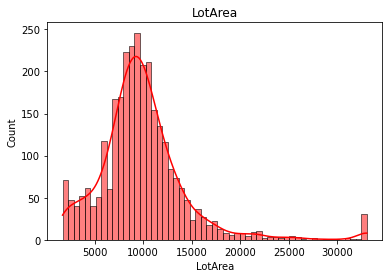

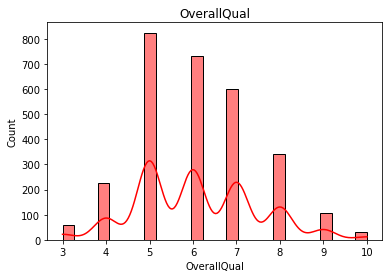

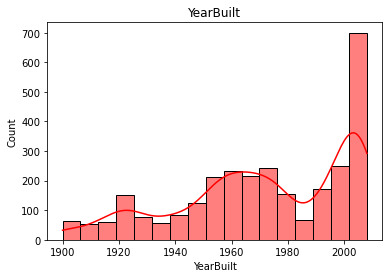

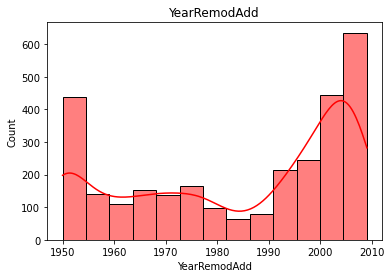

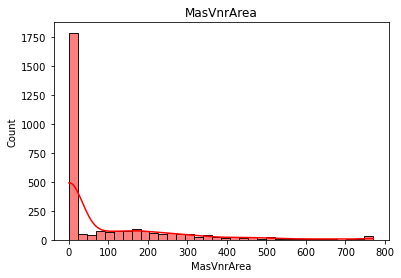

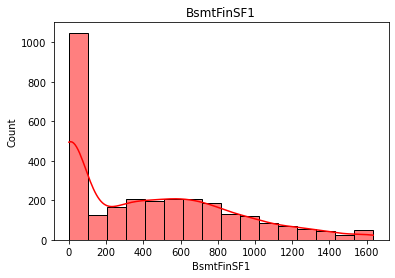

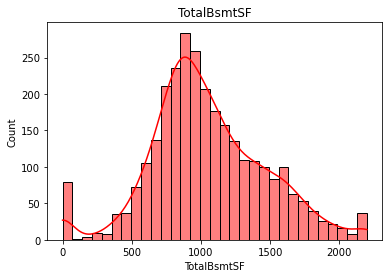

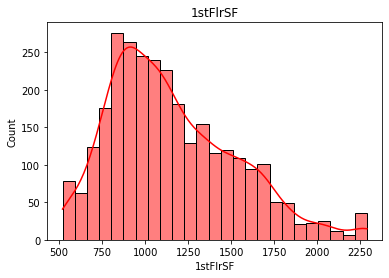

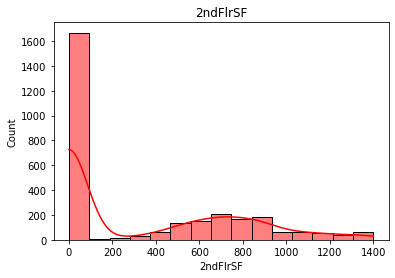

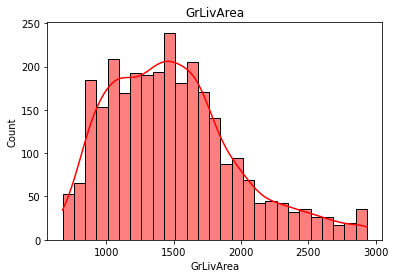

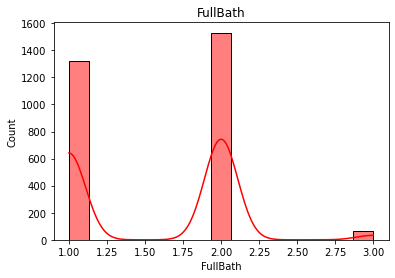

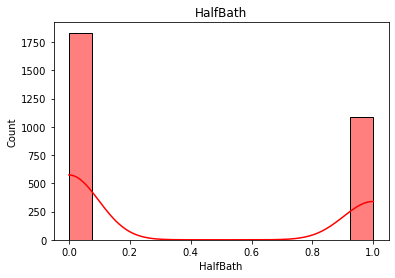

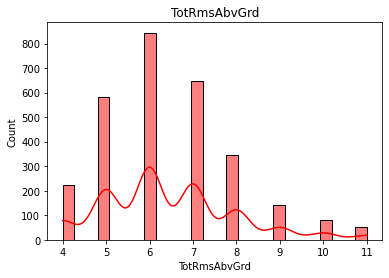

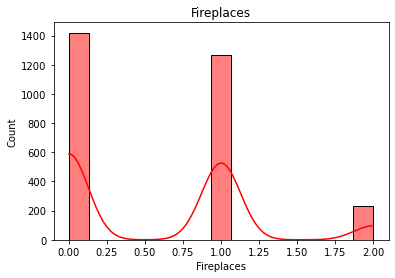

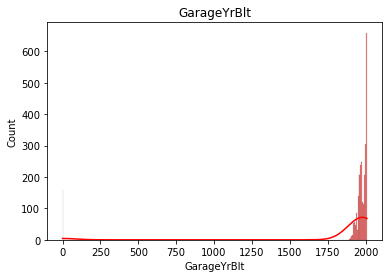

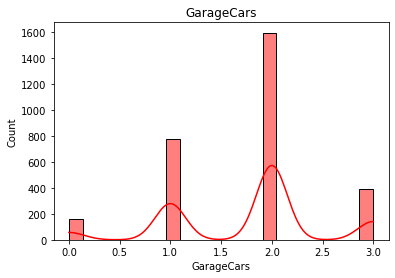

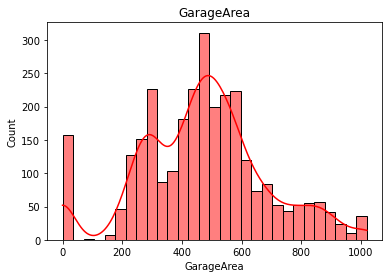

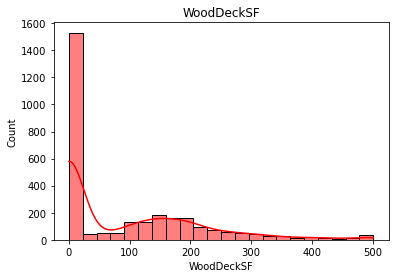

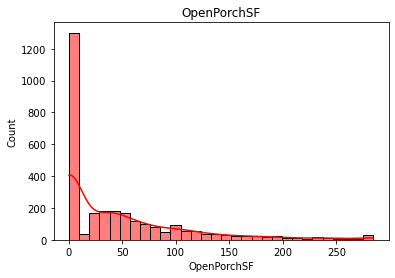

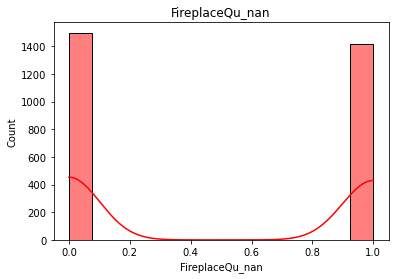

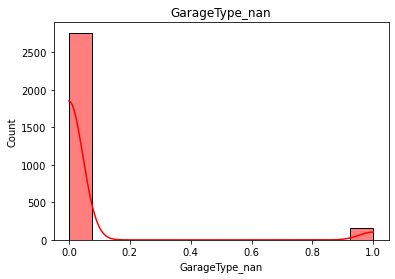

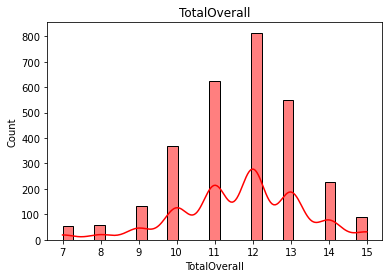

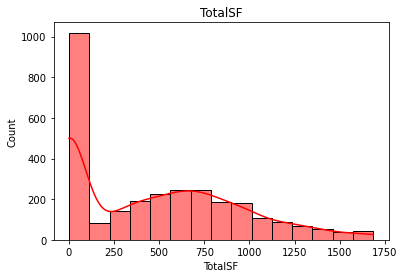

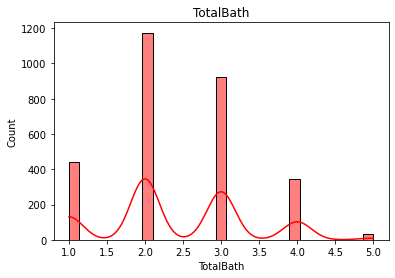

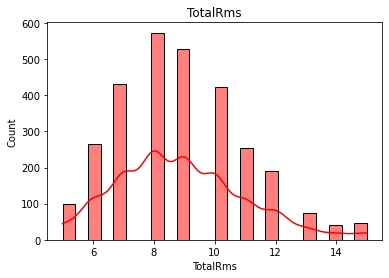

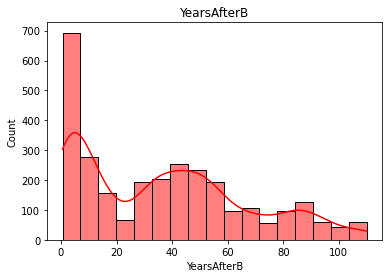

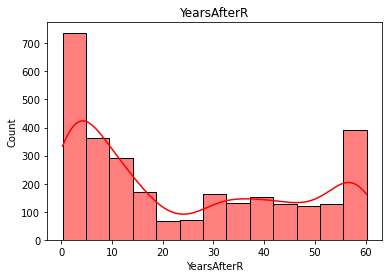

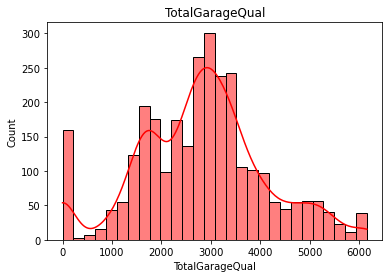

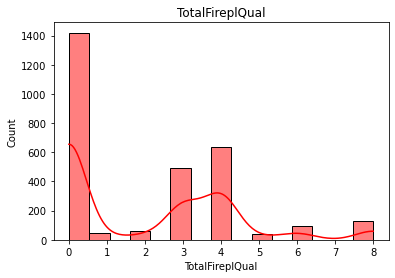

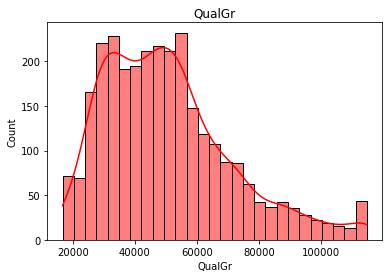

In [14]:
# Numerical
for feature in home_data_numerical_FeaSelect_pd.columns:
    sns.histplot(home_data_numerical_FeaSelect_pd[feature], kde = True, color = 'red', stat = 'count')
    plt.title(feature)
    plt.show()

# Feature Transformation

In [15]:
from sklearn import preprocessing

home_data_numerical_norm_pd = home_data_numerical_FeaSelect_pd.copy()

MinMax_scaler_list = []
MinMax_scaler_feature_list = []
for index, feature in enumerate(home_data_numerical_FeaSelect_pd.columns):
    min_max_scaler = preprocessing.MinMaxScaler()
    
    norm_list = min_max_scaler.fit_transform(
        home_data_numerical_FeaSelect_pd[home_data_numerical_FeaSelect_pd.columns[index:index+1]])
    
    home_data_numerical_norm_pd[feature] = norm_list + 1
    
    MinMax_scaler_feature_list.append(feature)
    MinMax_scaler_list.append(min_max_scaler)

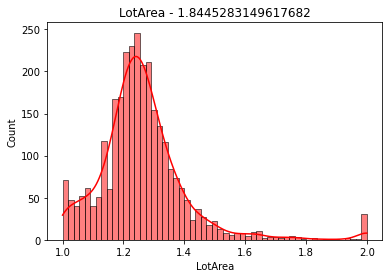

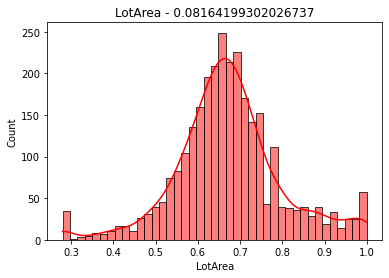

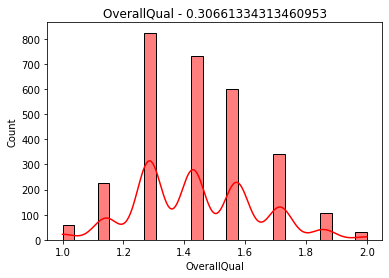

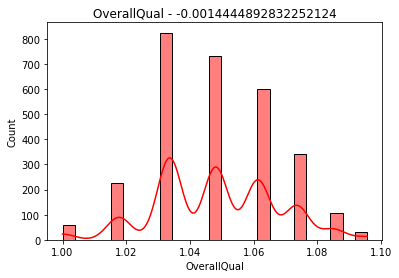

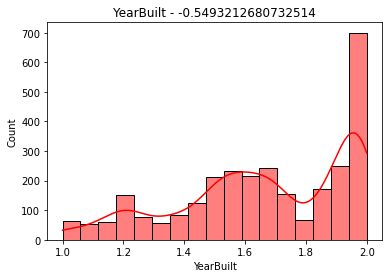

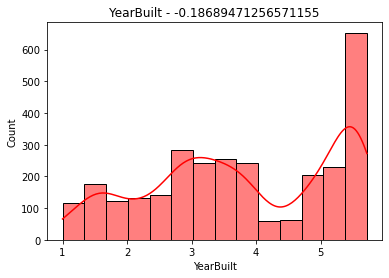

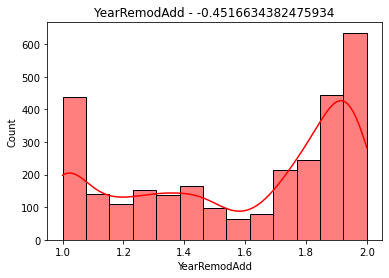

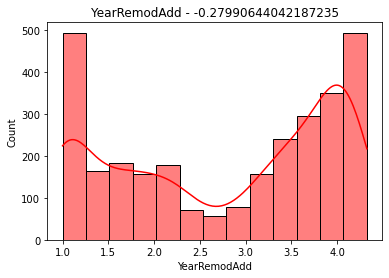

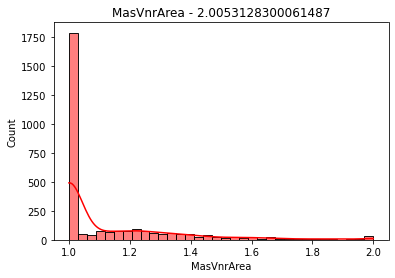

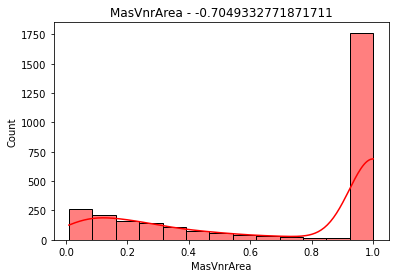

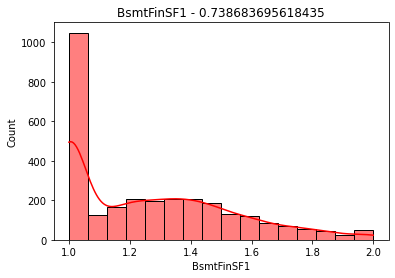

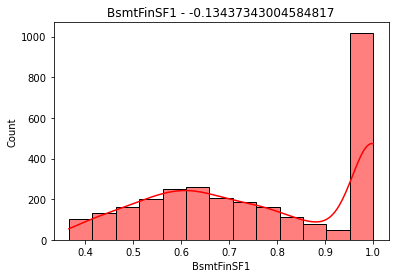

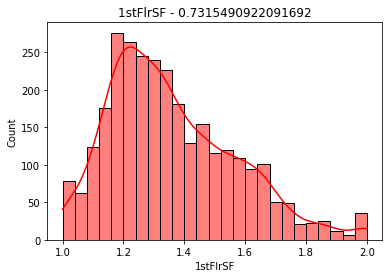

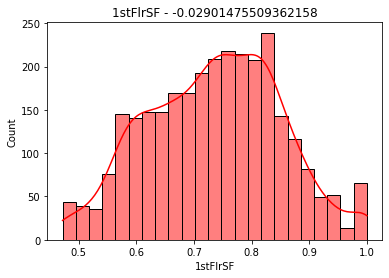

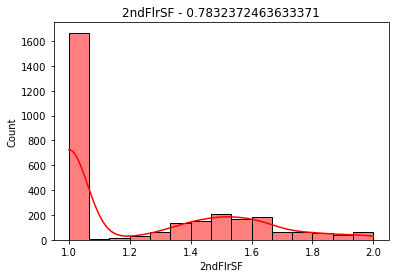

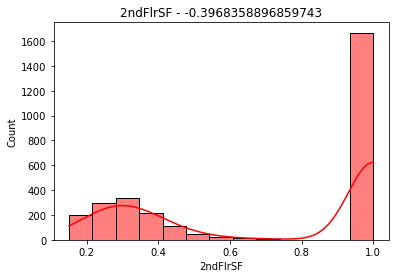

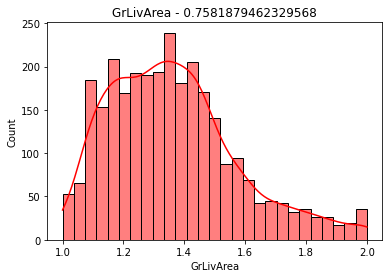

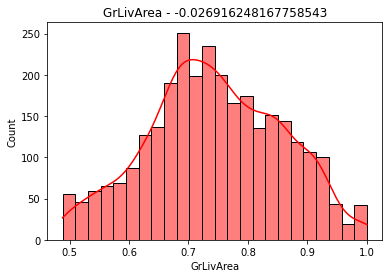

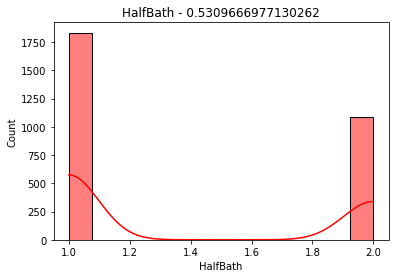

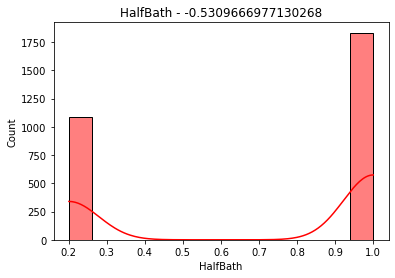

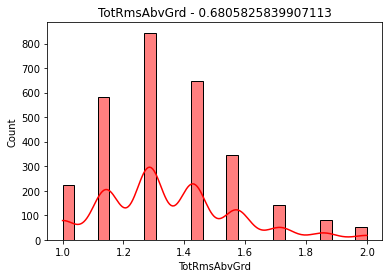

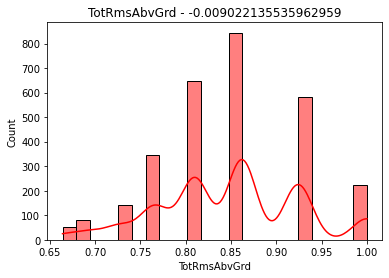

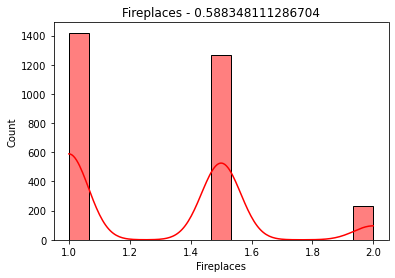

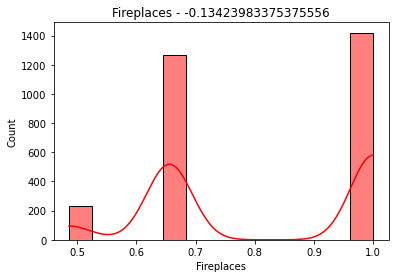

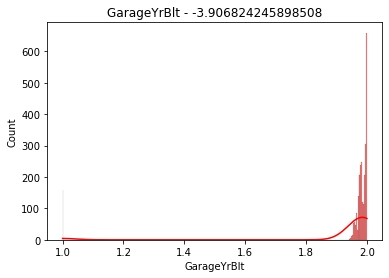

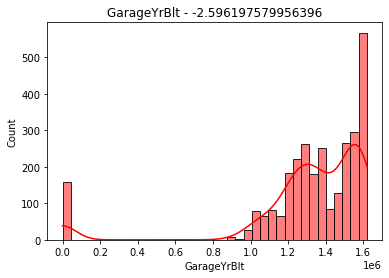

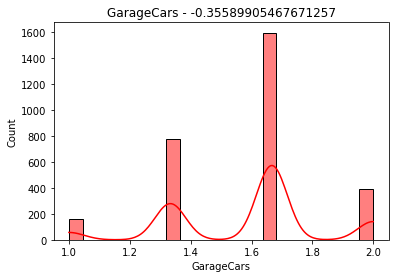

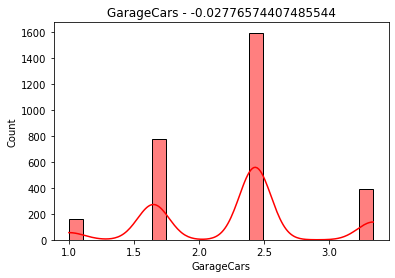

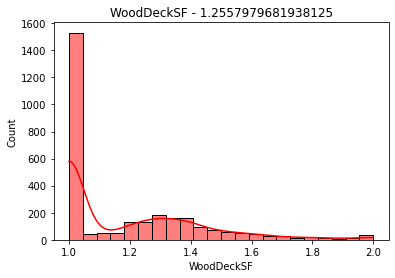

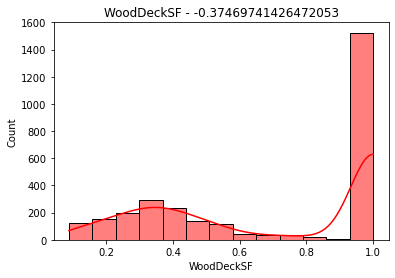

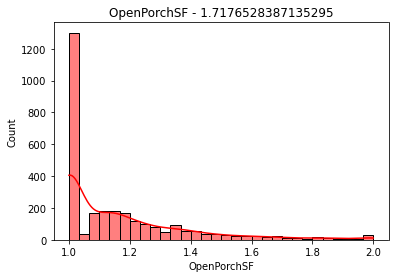

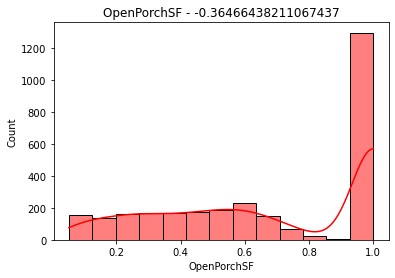

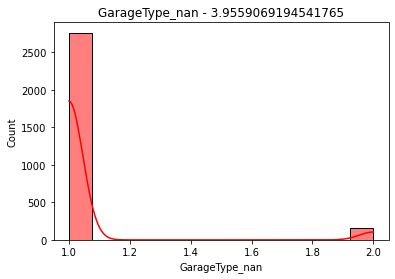

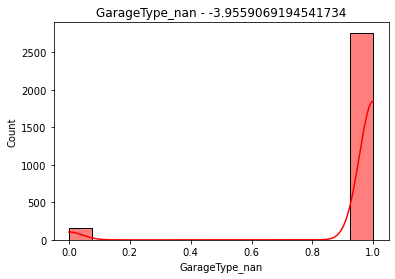

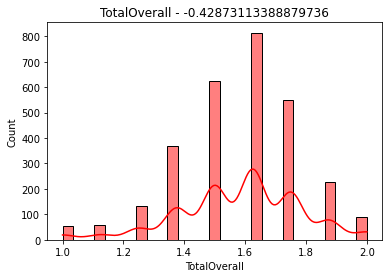

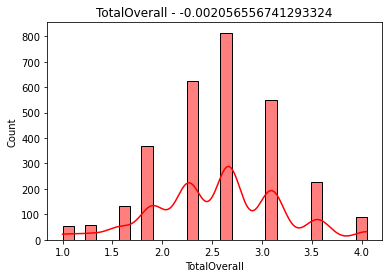

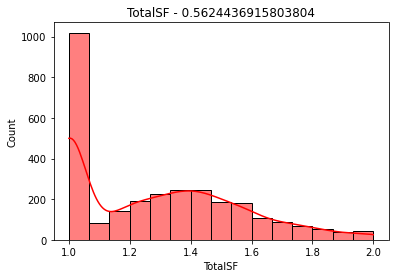

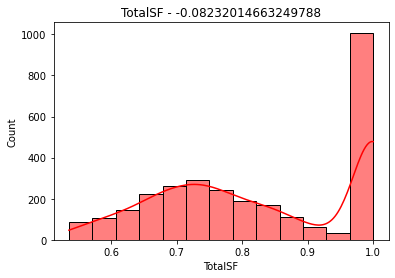

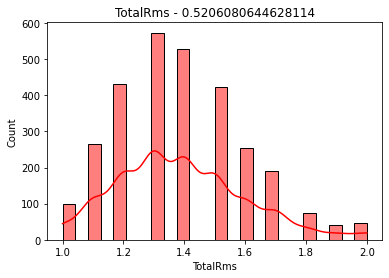

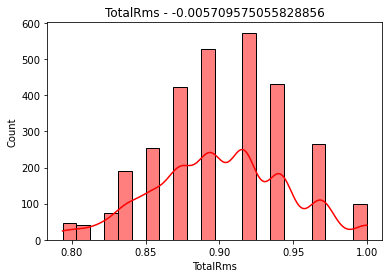

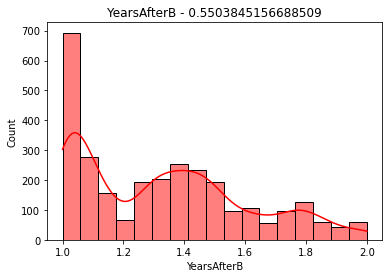

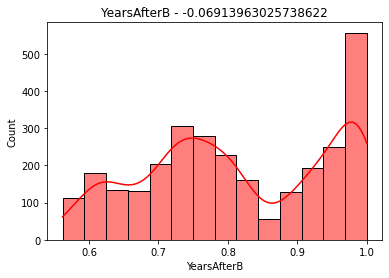

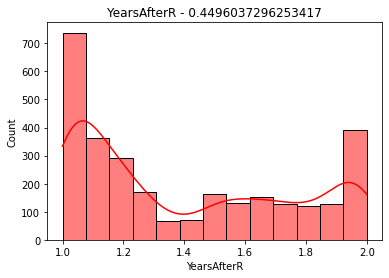

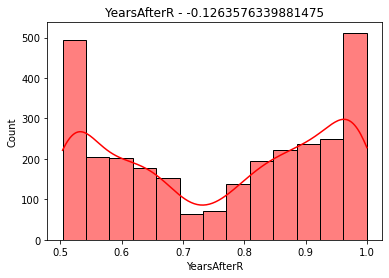

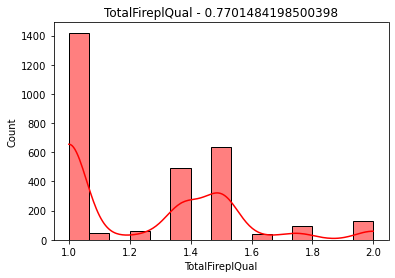

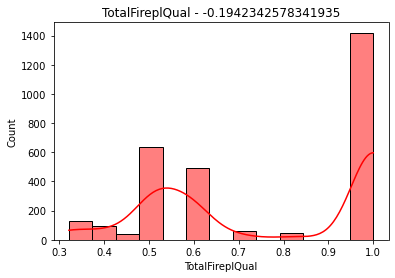

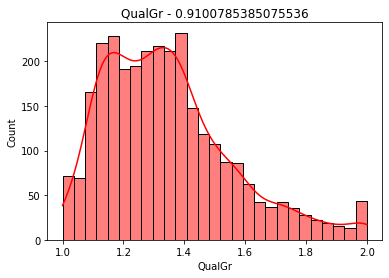

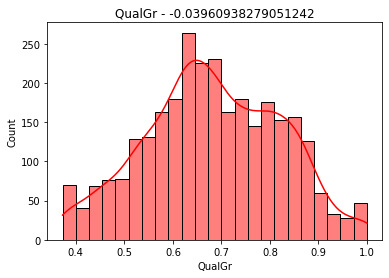

Columns len:,  30
Skewed Columns len:,  24


In [16]:
from scipy.stats import skew, boxcox

home_data_numerical_TR_pd = home_data_numerical_norm_pd.copy()

skew_feature_list = []
boxcox_lambda_list = []
for feature in home_data_numerical_norm_pd.columns:
    skew_value = skew(home_data_numerical_norm_pd[feature])
    if abs(skew_value) > 0.3:
        sns.histplot(home_data_numerical_norm_pd[feature], kde = True, color = 'red', stat = 'count')
        plt.title(feature + ' - ' + str(skew_value))
        plt.show()
        
        _, fitted_lambda = boxcox(home_data_numerical_norm_pd[feature])
        
        #home_data_numerical_TR_pd[feature] = boxcox(home_data_numerical_FeaSelect_pd[feature], lmbda=fitted_lambda)
        home_data_numerical_TR_pd[feature] = home_data_numerical_norm_pd[feature] ** fitted_lambda
        
        skew_value = skew(home_data_numerical_TR_pd[feature])
        
        sns.histplot(home_data_numerical_TR_pd[feature], kde = True, color = 'red', stat = 'count')
        plt.title(feature + ' - ' + str(skew_value))
        plt.show()
        
        skew_feature_list.append(feature)
        boxcox_lambda_list.append(fitted_lambda)

print('Columns len:, ', len(home_data_numerical_TR_pd.columns))
print('Skewed Columns len:, ', len(skew_feature_list))

# Preparation Data For Training

In [17]:
# Concatenate Categorical and Numerical
X = pd.concat([home_data_numerical_TR_pd[:][0:1460], home_data_categorical_FeaSelect_pd[:][0:1460]], axis=1)
X_testt = pd.concat([home_data_numerical_TR_pd[:][1460:], home_data_categorical_FeaSelect_pd[:][1460:]], axis=1)

# Select Feature
features = X.columns
print('X shape: ', X.shape)
print('X_testt shape: ', X_testt.shape)
print(X.head())

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

X shape:  (1460, 52)
X_testt shape:  (1459, 52)
    LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0  0.698306     1.061304   5.389796      3.873634    0.220426    0.593827   
1  0.661208     1.048072   3.819495      2.162782    1.000000    0.506224   
2  0.613068     1.061304   5.262220      3.800925    0.279921    0.685321   
3  0.662757     1.061304   1.386956      1.852868    1.000000    0.835134   
4  0.538136     1.073530   5.199121      3.657682    0.082195    0.613126   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  ...  GarageCond  PavedDrive  \
0     1.389410  0.828335  0.271700   0.677215  ...           3           3   
1     1.574106  0.684321  1.000000   0.787714  ...           3           3   
2     1.418524  0.801899  0.267781   0.661430  ...           3           3   
3     1.343918  0.785801  0.306841   0.675730  ...           3           3   
4     1.520881  0.720610  0.215551   0.587072  ...           3           3   

   TotalExter  Total

# Model Creating and Evaluating

In [18]:
# Models Import
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Score Metric
def scorer(y, y_pred):
    return mean_absolute_error(np.expm1(y_pred), np.expm1(y)), mean_absolute_error(y_pred, y)

# Model Selection

In [19]:
## Linear Model
# Rigde
Ridge_model = Ridge(random_state=42)
Ridge_scores = cross_val_score(Ridge_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('Ridge_scores: ', Ridge_scores.mean())

# Lasso
Lasso_model = Lasso(random_state=42)
Lasso_scores = cross_val_score(Lasso_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('Lasso_scores: ', Lasso_scores.mean())

# ElasticNet
elasticnet_model = ElasticNet(random_state=42)
elasticnet_scores = cross_val_score(elasticnet_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('elasticnet_scores: ', elasticnet_scores.mean())

# ElasticNetCV
elasticnetcv_model = ElasticNetCV(random_state=42)
elasticnetcv_scores = cross_val_score(elasticnetcv_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('elasticnetcv_scores: ', elasticnetcv_scores.mean())

Ridge_scores:  -0.09402469480850353
Lasso_scores:  -0.2588310018964314
elasticnet_scores:  -0.20907494762454207
elasticnetcv_scores:  -0.25952397564111207


In [20]:
## NonLinear Model
svr_model = make_pipeline(StandardScaler(), SVR())
svr_scores = cross_val_score(svr_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('svr_scores: ', svr_scores.mean())


svr_scores:  -0.10023891284022317


In [21]:
## Tree Model
# GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_scores = cross_val_score(gbr_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('gbr_scores: ', gbr_scores.mean())

# RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_scores = cross_val_score(rf_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('rf_scores: ', rf_scores.mean())

# XGBRegressor
xgbr_model = XGBRegressor(random_state=42)
xgbr_scores = cross_val_score(xgbr_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('xgbr_scores: ', xgbr_scores.mean())

# LGBMRegressor
lgbmr_model = LGBMRegressor(random_state=42)
lgbmr_scores = cross_val_score(lgbmr_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('lgbmr_scores: ', lgbmr_scores.mean())

# CatBoostRegressor
cbr_model = CatBoostRegressor(random_state=42)
cbr_scores = cross_val_score(cbr_model, train_X, train_y, scoring='neg_mean_absolute_error', cv=5)
print('cbr_scores: ', cbr_scores.mean())

gbr_scores:  -0.09241179094772464
rf_scores:  -0.0958744923880506
xgbr_scores:  -0.1061547636374572
lgbmr_scores:  -0.09737410650821847
Learning rate set to 0.038121
0:	learn: 0.3750455	total: 57.5ms	remaining: 57.5s
1:	learn: 0.3663985	total: 62.3ms	remaining: 31.1s
2:	learn: 0.3579144	total: 67.2ms	remaining: 22.3s
3:	learn: 0.3490509	total: 71.4ms	remaining: 17.8s
4:	learn: 0.3401801	total: 75.9ms	remaining: 15.1s
5:	learn: 0.3323301	total: 80.1ms	remaining: 13.3s
6:	learn: 0.3244001	total: 84.7ms	remaining: 12s
7:	learn: 0.3170633	total: 89.1ms	remaining: 11s
8:	learn: 0.3102964	total: 93.6ms	remaining: 10.3s
9:	learn: 0.3035379	total: 98.1ms	remaining: 9.71s
10:	learn: 0.2973268	total: 102ms	remaining: 9.21s
11:	learn: 0.2909739	total: 107ms	remaining: 8.77s
12:	learn: 0.2844513	total: 111ms	remaining: 8.41s
13:	learn: 0.2782554	total: 114ms	remaining: 8.05s
14:	learn: 0.2724013	total: 118ms	remaining: 7.77s
15:	learn: 0.2667380	total: 122ms	remaining: 7.52s
16:	learn: 0.2618258	t

# Selected Model List
* Ridge_scores:  -0.09298470682146234
* svr_scores:  -0.10092978263669142
* gbr_scores:  -0.0951356795498814
* lgbmr_scores:  -0.09877971571698899
* cbr_scores:  -0.09119231031739358

# Select Model Parameters

In [22]:
## Liner Model
# Ridge
ridge_params = {
    'alpha': [0.33, 0.66, 1, 1.5, 2.5, 5, 8, 12]
}

## NonLinear Model
# SVR
svr_params = {
    'svr__C' : [9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16],
    'svr__gamma' : [0.0001, 0.0003, 0.0005, 0.0007, 0.0009, 0.0011],
}

## Tree Model
# GradientBoostingRegressor
gbr_params = {
    'learning_rate' : [0.001, 0.01, 0.10, 0.15, 0.3, 0.5, 0.1],
    'n_estimators' : [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'max_depth' : [2, 4, 6, 8]
}

# LGBMRegressor
lgbmr_params = {
    'max_depth' : [2, 4, 6, 8],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.2, 0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

# CatBoostRegressor
cbr_params = {
    'n_estimators' : [100, 300, 500, 1000, 1300, 1600, 2000],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2],
    'l2_leaf_reg' : [0.001, 0.01, 0.1, 1, 3],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [1, 2, 5, 10, 15, 20],
    'rsm' : [0.3, 0.5, 0.7, 0.9, 1],
}

In [23]:
ridge_model = Ridge(random_state=42)
svr_model = make_pipeline(StandardScaler(), SVR())
gbr_model = GradientBoostingRegressor(random_state=42)
lgbmr_model = LGBMRegressor(boosting_type='gbdt',objective='regression', random_state=42)
cbr_model = CatBoostRegressor(loss_function='RMSE', allow_writing_files=False, logging_level='Silent', random_state=42)

# Fit and Evaluate Models

In [24]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Ridge
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
ridge_grid.fit(train_X, train_y)

# SVR
svr_grid = GridSearchCV(svr_model, svr_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
svr_grid.fit(train_X, train_y)

print('svr_grid.best_params_: ', svr_grid.best_params_)
print('svr_grid score: ', scorer(val_y, svr_grid.best_estimator_.predict(val_X)))

# GradientBoostingRegressor
gbr_grid = RandomizedSearchCV(gbr_model, param_distributions=gbr_params, n_iter=100, cv=5, 
                              scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
gbr_grid.fit(train_X, train_y)

# LGBMRegressor
lgbmr_grid = RandomizedSearchCV(lgbmr_model, param_distributions=lgbmr_params, n_iter=100, cv=5, 
                                  scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
lgbmr_grid.fit(train_X, train_y)

# CatBoostRegressor
cbr_grid = RandomizedSearchCV(cbr_model, param_distributions=cbr_params, n_iter=100, cv=5, 
                                scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
cbr_grid.fit(train_X, train_y)

print('Best Params')
print('ridge_grid.best_params_: ', ridge_grid.best_params_)
print('svr_grid.best_params_: ', svr_grid.best_params_)
print('gbr_grid.best_params_: ', gbr_grid.best_params_)
print('lgbmr_grid.best_params_: ', lgbmr_grid.best_params_)
print('cbr_grid.best_params_: ', cbr_grid.best_params_)

print('Scores')
print('ridge_grid score: ', scorer(val_y, ridge_grid.best_estimator_.predict(val_X)))
print('svr_grid score: ', scorer(val_y, svr_grid.best_estimator_.predict(val_X)))
print('gbr_grid score: ', scorer(val_y, gbr_grid.best_estimator_.predict(val_X)))
print('lgbmr_grid score: ', scorer(val_y, lgbmr_grid.best_estimator_.predict(val_X)))
print('cbr_grid score: ', scorer(val_y, cbr_grid.best_estimator_.predict(val_X)))

svr_grid.best_params_:  {'svr__C': 12.5, 'svr__gamma': 0.0005}
svr_grid score:  (14705.072978598178, 0.08583021169072332)
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Params
ridge_grid.best_params_:  {'alpha': 0.66}
svr_grid.best_params_:  {'svr__C': 12.5, 'svr__gamma': 0.0005}
gbr_grid.best_params_:  {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01}
lgbmr_grid.best_params_:  {'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.01, 'lambda_l2': 0.001, 'lambda_l1': 0.001, 'feature_fraction': 0.2}
cbr_grid.best_params_:  {'rsm': 1, 'random_strength': 1, 'n_estimators': 2000, 'min_child_samples': 20, 'max_depth': 6, 'learning_rate': 0.01, 'l2_leaf_reg': 0.1}
Scores
ridge_grid score:  (15689.121892949592, 0.08969295071274812)
svr_grid score:  (14705.072978598178, 0.08583021169072332)
gbr_grid score:  (15274.741322015196, 0.08787761696111307)
lgbmr_grid score:  (15359.671090676055, 0.08744531186109963)
cbr_grid score:  (14557.622257003744, 0.08293172753805052)


# Selected Params and Score
* ridge_grid.best_params_:  {'alpha': 0.66}
* ridge_grid score:  (15400.131960269626, 0.08748186772893962)
* svr_grid.best_params_:  {'svr__C': 11.5, 'svr__gamma': 0.0009}
* svr_grid score:  (14320.386583957852, 0.08381348818893232)
* gbr_grid.best_params_:  {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.01}
* gbr_grid score:  (15508.105921103934, 0.08891425898317618)
* lgbmr_grid.best_params_:  {'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.01, 'lambda_l2': 0.001, 'lambda_l1': 0.001, 'feature_fraction': 0.2}
* lgbmr_grid score:  (14722.40413231814, 0.0839935711705483)
* cbr_grid.best_params_:  {'rsm': 1, 'random_strength': 1, 'n_estimators': 2000, 'min_child_samples': 20, 'max_depth': 6, 'learning_rate': 0.01, 'l2_leaf_reg': 0.1}
* cbr_grid score:  (14447.235579239596, 0.08263041721048965)

# Fit Stacked Models

In [25]:
from sklearn.ensemble import StackingRegressor

ridge = Ridge(alpha=0.66, random_state=42)
svr = make_pipeline(StandardScaler(), SVR(C=10, gamma=0.0005))
gbr = GradientBoostingRegressor(n_estimators=3000, max_depth=2, learning_rate=0.01, random_state=42)
lgbmr = LGBMRegressor(n_estimators=500, min_child_samples=10, max_depth=6, learning_rate=0.01, 
                            lambda_l2=0.001, lambda_l1=0.001, feature_fraction=0.2,
                            boosting_type='gbdt',objective='regression', random_state=42)
cbr = CatBoostRegressor(rsm=1, random_strength=1, n_estimators=2000, min_child_samples=20, 
                              max_depth=6, learning_rate=0.01, l2_leaf_reg=0.1,
                              loss_function='RMSE', allow_writing_files=False, logging_level='Silent', random_state=42)

estimators = [
        ('ridge', ridge),
        ('svr', svr),
        ('gbr', gbr),
        ('lgbmr', lgbmr),
        ('cbr', cbr)
]

stacked_reg = StackingRegressor(estimators=estimators, final_estimator=ridge, 
                                n_jobs=-1, verbose=4, cv=5)
stacked_reg.fit(X, y)

StackingRegressor(cv=5,
                  estimators=[('ridge', Ridge(alpha=0.66, random_state=42)),
                              ('svr',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr',
                                                SVR(C=10, gamma=0.0005))])),
                              ('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=2,
                                                         n_estimators=3000,
                                                         random_state=42)),
                              ('lgbmr',
                               LGBMRegressor(feature_fraction=0.2,
                                             lambda_l1=0.001, lambda_l2=0.001,
                                             learning_rate=0.01, max_dept

# Make Predictions
Read the file of "test" data. And apply your model to make predictions

In [26]:
# make predictions which we will submit. 
test_preds = stacked_reg.predict(X_testt)
test_preds_full = np.expm1(test_preds)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.

output_gbr = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds_full})
output_gbr.to_csv('submission.csv', index=False)

In [27]:
# path to file you will use for predictions
test_data_path = '../input/test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

# Split Categorical and Numerical
test_data_categorical_pd  = test_data.loc[:,test_data.dtypes==np.object]
test_data_numerical_pd  = test_data.loc[:,test_data.dtypes!=np.object]
test_data_numerical_pd = test_data_numerical_pd.drop(columns=['Id'])

# Create NaN Columns
df_numerical_nan = pd.DataFrame()
for feature in numerical_nan_features:
    bool_nan = test_data_numerical_pd[feature[0:-4]].isnull()
    df_numerical_nan[feature] = bool_nan.astype('uint8')

df_categorical_nan = pd.DataFrame()
for feature in categorical_nan_features:
    bool_nan = test_data_categorical_pd[feature[0:-4]].isnull()
    df_categorical_nan[feature] = bool_nan.astype('uint8')
    
test_data_numerical_withnan_pd = pd.concat([test_data_numerical_pd, df_numerical_nan], axis=1)
test_data_numerical_withnan_pd = pd.concat([test_data_numerical_pd, df_categorical_nan], axis=1)

# Fill NaN
test_data_numerical_filledna_pd = test_data_numerical_withnan_pd.fillna(0)

test_data_categorical_filledna_pd = test_data_categorical_pd.copy()
for feature in test_data_categorical_pd.columns:
    test_data_categorical_filledna_pd[feature] = test_data_categorical_pd[feature].fillna('None')

In [28]:
# Label Encode
test_data_categorical_encoded_pd = test_data_categorical_filledna_pd.copy()
for i, feature in enumerate(test_data_categorical_filledna_pd.columns):
    encoded_data = [encode_dict_list[i].get(x) for x in test_data_categorical_filledna_pd[feature]]
    test_data_categorical_encoded_pd[feature] = encoded_data

In [29]:
# Feature Engineering
# Numerical
test_data_numerical_feaEng_pd = test_data_numerical_filledna_pd.copy()
print(test_data_numerical_feaEng_pd.columns)

test_data_numerical_feaEng_pd['TotalOverall'] = test_data_numerical_filledna_pd['OverallQual'] + test_data_numerical_filledna_pd['OverallCond']
test_data_numerical_feaEng_pd['DiffYearRemodAdd'] = test_data_numerical_filledna_pd['YearRemodAdd'] - test_data_numerical_filledna_pd['YearBuilt']
test_data_numerical_feaEng_pd['TotalSF'] = test_data_numerical_filledna_pd['BsmtFinSF1'] + test_data_numerical_filledna_pd['BsmtFinSF2']
test_data_numerical_feaEng_pd['TotalBath'] = test_data_numerical_filledna_pd['BsmtFullBath'] + test_data_numerical_filledna_pd['BsmtHalfBath'] + test_data_numerical_filledna_pd['FullBath'] + test_data_numerical_filledna_pd['HalfBath']
test_data_numerical_feaEng_pd['TotalRms'] = test_data_numerical_filledna_pd['TotRmsAbvGrd'] + test_data_numerical_feaEng_pd['TotalBath']
test_data_numerical_feaEng_pd['TotalPorch'] = test_data_numerical_filledna_pd['OpenPorchSF'] + test_data_numerical_filledna_pd['EnclosedPorch'] + test_data_numerical_filledna_pd['3SsnPorch'] + test_data_numerical_filledna_pd['ScreenPorch']
test_data_numerical_feaEng_pd['YearSold'] = test_data_numerical_filledna_pd['MoSold'] / 12 + test_data_numerical_filledna_pd['YrSold'].astype('int')
test_data_numerical_feaEng_pd['YearsAfterB'] = test_data_numerical_feaEng_pd['YearSold'] - test_data_numerical_filledna_pd['YearBuilt']
test_data_numerical_feaEng_pd['YearsAfterR'] = test_data_numerical_feaEng_pd['YearSold'] - test_data_numerical_filledna_pd['YearRemodAdd']

# Categorical
test_data_categorical_feaEng_pd = test_data_categorical_encoded_pd.copy()
print(test_data_categorical_feaEng_pd.columns)

test_data_categorical_feaEng_pd['TotalExter'] = test_data_categorical_encoded_pd['ExterQual'] + test_data_categorical_encoded_pd['ExterCond']
test_data_categorical_feaEng_pd['TotalBsmt'] = test_data_categorical_encoded_pd['BsmtQual'] + test_data_categorical_encoded_pd['BsmtCond']
test_data_categorical_feaEng_pd['TotalBsmtFinType'] = test_data_categorical_encoded_pd['BsmtFinType1'] + test_data_categorical_encoded_pd['BsmtFinType2']
test_data_categorical_feaEng_pd['TotalGarage'] = test_data_categorical_encoded_pd['GarageQual'] + test_data_categorical_encoded_pd['GarageCond']
test_data_categorical_feaEng_pd['TotalPoolFenceQual'] = test_data_categorical_encoded_pd['PoolQC'] + test_data_categorical_encoded_pd['Fence']

test_data_categorical_feaEng_pd['TotalQual'] = (test_data_numerical_feaEng_pd['TotalOverall'] + 
                                               test_data_categorical_feaEng_pd['TotalExter'] + 
                                               test_data_categorical_feaEng_pd['TotalBsmt'] + 
                                                test_data_categorical_encoded_pd['HeatingQC'] + 
                                               test_data_categorical_encoded_pd['FireplaceQu'] + 
                                                test_data_categorical_feaEng_pd['TotalPoolFenceQual'] + 
                                               test_data_categorical_encoded_pd['CentralAir'])

test_data_categorical_feaEng_pd['HasPool'] = test_data_numerical_filledna_pd['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_data_categorical_feaEng_pd['Has2ndFloor'] = test_data_numerical_filledna_pd['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test_data_categorical_feaEng_pd['HasGarage'] = test_data_numerical_filledna_pd['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test_data_categorical_feaEng_pd['HasFireplace'] = test_data_numerical_filledna_pd['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
test_data_categorical_feaEng_pd['HasPorch'] = test_data_numerical_feaEng_pd['TotalPorch'].apply(lambda x: 1 if x > 0 else 0)
test_data_categorical_feaEng_pd['HasLotFr'] = test_data_numerical_filledna_pd['LotFrontage'].apply(lambda x: 1 if x > 0 else 0)
test_data_categorical_feaEng_pd['HasFence'] = test_data_categorical_encoded_pd['Fence'].apply(lambda x: 1 if x > 0 else 0)
test_data_categorical_feaEng_pd['WasRemod'] = (test_data_numerical_filledna_pd['YearRemodAdd'] != test_data_numerical_filledna_pd['YearBuilt']).apply(lambda x: 1 if x == True else 0)

# Numerical
test_data_numerical_feaEng_pd['TotalGarageQual'] = test_data_categorical_feaEng_pd['TotalGarage'] * test_data_numerical_feaEng_pd['GarageArea']
test_data_numerical_feaEng_pd['TotalPoolQual'] = test_data_categorical_encoded_pd['PoolQC'] * test_data_numerical_feaEng_pd['PoolArea']
test_data_numerical_feaEng_pd['TotalFireplQual'] = test_data_categorical_encoded_pd['FireplaceQu'] * test_data_numerical_feaEng_pd['Fireplaces']
test_data_numerical_feaEng_pd['QualGr'] = test_data_categorical_feaEng_pd['TotalQual'] * test_data_numerical_feaEng_pd['GrLivArea']

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'MSZoning_nan', 'Alley_nan', 'Utilities_nan',
       'Exterior1st_nan', 'Exterior2nd_nan', 'MasVnrType_nan', 'BsmtQual_nan',
       'BsmtCond_nan', 'BsmtExposure_nan', 'BsmtFinType1_nan',
       'BsmtFinType2_nan', 'Electrical_nan', 'KitchenQual_nan',
       'Functional_nan', 'FireplaceQu_nan', 'GarageType_nan',
       'GarageFinish_nan', 'GarageQual_nan', 'GarageCond_nan', 'PoolQC_nan',
       'Fence_nan', 'MiscFeature_nan', 'SaleType_nan'

In [30]:
# Delete Outliers
test_data_numerical_outlier_pd = test_data_numerical_feaEng_pd.copy()
for feature in test_data_numerical_feaEng_pd.columns:
    print(test_data_numerical_feaEng_pd[feature].describe())
    print('max: ', test_data_numerical_feaEng_pd[feature].max())
    print('Quantile Upper: ', test_data_numerical_feaEng_pd[feature].quantile(.99))
    print('Quantile Lower: ', test_data_numerical_feaEng_pd[feature].quantile(.01))
    test_data_numerical_outlier_pd[feature].clip(upper=test_data_numerical_feaEng_pd[feature].quantile(.99), 
                                                 inplace=True)
    test_data_numerical_outlier_pd[feature].clip(lower=test_data_numerical_feaEng_pd[feature].quantile(.01), 
                                                 inplace=True)
    print(test_data_numerical_outlier_pd[feature].describe())

count    1459.000000
mean       57.378341
std        42.746880
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64
max:  190
Quantile Upper:  190.0
Quantile Lower:  20.0
count    1459.000000
mean       57.378341
std        42.746880
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64
count    1459.000000
mean       57.910212
std        32.266054
min         0.000000
25%        44.000000
50%        63.000000
75%        78.000000
max       200.000000
Name: LotFrontage, dtype: float64
max:  200.0
Quantile Upper:  129.42000000000007
Quantile Lower:  0.0
count    1459.000000
mean       57.706854
std        31.672513
min         0.000000
25%        44.000000
50%        63.000000
75%        78.000000
max       129.420000
Name: LotFrontage, dtype: float64
count     1459.000000
mean      9819.161069
std       4955.517327
min 

In [31]:
# Normalize Data
test_data_numerical_norm_pd = test_data_numerical_outlier_pd.copy()

numerical_feature_list = []
for feature in test_data_numerical_outlier_pd.columns:
    if feature in features:
        numerical_feature_list.append(feature)
        
print(MinMax_scaler_feature_list)
print(numerical_feature_list)

for index, feature in enumerate(numerical_feature_list):
    norm_list = MinMax_scaler_list[index].transform(
            test_data_numerical_outlier_pd[test_data_numerical_outlier_pd.columns[index:index+1]])

    test_data_numerical_norm_pd[feature] = norm_list + 1

['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'FireplaceQu_nan', 'GarageType_nan', 'TotalOverall', 'TotalSF', 'TotalBath', 'TotalRms', 'YearsAfterB', 'YearsAfterR', 'TotalGarageQual', 'TotalFireplQual', 'QualGr']
['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'FireplaceQu_nan', 'GarageType_nan', 'TotalOverall', 'TotalSF', 'TotalBath', 'TotalRms', 'YearsAfterB', 'YearsAfterR', 'TotalGarageQual', 'TotalFireplQual', 'QualGr']


In [32]:
# Transform Data
test_data_numerical_TR_pd = test_data_numerical_norm_pd.copy()

for index, feature in enumerate(skew_feature_list):
        test_data_numerical_TR_pd[feature] = home_data_numerical_norm_pd[feature] ** boxcox_lambda_list[index]

print('Columns len:, ', len(test_data_numerical_TR_pd.columns))
print('Skewed Columns len:, ', len(skew_feature_list))

ValueError: cannot reindex from a duplicate axis

In [33]:
# Concatenate Categorical and Numerical
test_X = pd.concat([test_data_numerical_TR_pd, test_data_categorical_feaEng_pd], axis=1)

# Select Feature
test_X = test_X[features]
print('X shape: ', X.shape)
print(X.head())

X shape:  (1460, 52)
    LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0  0.698306     1.061304   5.389796      3.873634    0.220426    0.593827   
1  0.661208     1.048072   3.819495      2.162782    1.000000    0.506224   
2  0.613068     1.061304   5.262220      3.800925    0.279921    0.685321   
3  0.662757     1.061304   1.386956      1.852868    1.000000    0.835134   
4  0.538136     1.073530   5.199121      3.657682    0.082195    0.613126   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  ...  GarageCond  PavedDrive  \
0     1.389410  0.828335  0.271700   0.677215  ...           3           3   
1     1.574106  0.684321  1.000000   0.787714  ...           3           3   
2     1.418524  0.801899  0.267781   0.661430  ...           3           3   
3     1.343918  0.785801  0.306841   0.675730  ...           3           3   
4     1.520881  0.720610  0.215551   0.587072  ...           3           3   

   TotalExter  TotalBsmt  TotalBsmtFinType  Tot

In [34]:
# make predictions which we will submit. 
test_preds = stacked_reg.predict(test_X)
test_preds_full = np.expm1(test_preds)

# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.

#output_gbr = pd.DataFrame({'Id': test_data.Id,
#                       'SalePrice': test_preds_full})
#output_gbr.to_csv('submission.csv', index=False)

Before submitting, run a check to make sure your `test_preds` have the right format.

In [35]:
# Check your answer
step_1.check()
# step_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

# Test Your Work

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on [this link](https://www.kaggle.com/c/home-data-for-ml-course).  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continuing Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  Look at the list of columns and think about what might affect home prices.  Some features will cause errors because of issues like missing values or non-numeric data types. 

The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.


# Other Courses
The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161285) to chat with other Learners.*